## Human In The Loop Interruption

These are useful when we want to approve the decision whether to reject or approve. Just like the `HumanInTheLoopMiddleware` we previously used in the Langchain.

We are going to take the example used in our previous tutorials.

### Static Interrupt

In [6]:

from langchain_google_genai import ChatGoogleGenerativeAI


In [2]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
)

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

In [4]:
llm_with_tools = llm.bind_tools(tools)

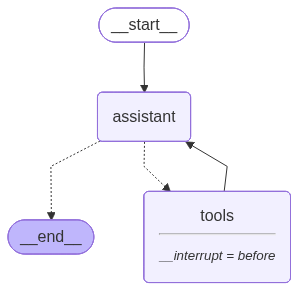

In [7]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In the Above code while compiling the Graph we have added the parameter `interrupt_before` which takes the list of nodes to interrupt before calling the node. 

In [8]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

d:\testing\Langchain_Tutorial\Langgraph Tutorial\.venv\Lib\site-packages\pydantic\v1\main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (958640a8-31e7-49eb-860c-35938265f5e9)
 Call ID: 958640a8-31e7-49eb-860c-35938265f5e9
  Args:
    a: 2
    b: 3


In [9]:
state = graph.get_state(thread)
state.next

('tools',)

Now, we'll introduce a nice trick.

When we invoke the graph with None, it will just continue from the last state checkpoint!

In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (958640a8-31e7-49eb-860c-35938265f5e9)
 Call ID: 958640a8-31e7-49eb-860c-35938265f5e9
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


Also in the official documentation of the Langgraph they mention to not to use static interrupts instead make use of the Interrupt method. 

**Static Interrupt**: Static Interrupt are those which are defined before or after the specific nodes. 

**Dynamic Interrupt**: Dynamic Interrupt are those which are invoked dynamically using the `interrupt()` method specifically in the tool call or any inside the node. Which will see in the later sections

### Dynamic Interrupt

Dynamic Interrupt is flexible you can place it any where in the code based on our conditional logic. Even though we can pass the input from the interrupt message provided by the message and use that message.

Lets create the node with `interrupt()`function 

In [ ]:
from langgraph.types import interrupt
from langgraph.graph import END


def approval_node(state: MessagesState) -> MessagesState:
    response = interrupt("Are you sure you want to continue ?")
    if response:
        return {"messages": [HumanMessage("User is approved")]}
    return {"messages": [HumanMessage("User is not giving approval")]}

In these node we have defined the `interrupt` function based on the response we receive from the Command we will resume.

In [14]:
def assistant_node(state: MessagesState) -> MessagesState:
    system_message = SystemMessage(
        "You are helpful assistant. Your work is ask if you want to edit the file if user give approval then write the paragraph based on the provded topic. "
    )
    response = llm.invoke([system_message] + state["messages"])
    return {"messages": response}

Creating the Graph

In [16]:
memory = MemorySaver()

In [17]:
interruptiongraph = StateGraph(MessagesState)
interruptiongraph.add_node("approval",approval_node)
interruptiongraph.add_node("assistant",assistant_node)

# defining the edges
interruptiongraph.add_edge(START,"approval")
interruptiongraph.add_edge("approval","assistant")
interruptiongraph.add_edge("assistant",END)

# compile the graph
compile_graph = interruptiongraph.compile(checkpointer=memory)

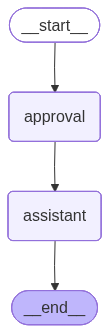

In [18]:
from IPython.display import display,Image

display(Image(compile_graph.get_graph().draw_mermaid_png()))

Invoking the Graph

In [28]:
from langchain_core.runnables import RunnableConfig

config: RunnableConfig = {"configurable": {"thread_id": 13}}

In [29]:
initial_input:MessagesState={
    'messages':[HumanMessage("topic is User Sensitive Information")]
}

async for chunk in compile_graph.astream(initial_input,config,stream_mode="updates"):
    print(chunk)

{'__interrupt__': (Interrupt(value='Are you sure you want to continue ?', id='3ed96b59297c64c673e87feb559de084'),)}


Here we got the Interrupt for asking the approval from the user. Lets provide the response for it. 

In [30]:
from langgraph.types import Command

async for chunk in compile_graph.astream(Command(resume=True),config,stream_mode="updates"):
    print(chunk)

{'approval': {'messages': [HumanMessage(content='User is approved', additional_kwargs={}, response_metadata={}, id='ae5d280a-b7eb-4759-b7bb-a436b50c7ab2')]}}
{'assistant': {'messages': AIMessage(content='Yes, you have been approved. Do you want to edit the file?\n\nUser Sensitive Information encompasses any data about an individual that, if exposed or misused, could cause significant personal or financial harm, discrimination, or distress. This broad category includes directly identifiable data like full names, addresses, email addresses, and phone numbers, as well as more critical elements such as social security numbers, financial account details, medical records, biometric data, and even browsing history or location data when linked to an individual. The robust protection of this information is a fundamental requirement for any entity collecting it, necessitating advanced security protocols, strict data handling policies, and compliance with privacy regulations like CCPA or GDPR to 